# Dynamic time warping

Predicts the species of each flash sequence by finding the shortest distance, using dynamic time warping, to literature or population references.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from dynamic_time_warping import *

Load binary sequence data, labels, and literature references.

In [2]:
# load sequences
seq_path = '../data/real_data/binary_sequences_7.csv'
df = pd.read_csv(seq_path, delimiter=',', header=None, names=list(range(2000))).dropna(axis='columns', how='all')
# load labels
labels_path = '../data/real_data/flash_data_7.csv'
labels = pd.read_csv(labels_path)
df = pd.concat([labels, df], axis="columns")
# keep only sequences with number of flashes > 1
meta_df = pd.read_csv('../data/params_7species.csv', names=['nf', 'fl', 'ifi', 'sp'])
df = df.loc[meta_df['nf'] > 1].reset_index(drop=True)

# load literature sequences (excludes Bw)
literature_sequences = []
literature_labels = []
header = 0
for l in open('../data/literature_sequences_6.csv'):
    if header > 0:
        header -= 1
        continue
    literature_sequences.append([int(float(x)) for x in l.rstrip().split(',')[1:]])
    literature_labels.append(l.rstrip().split(',')[0])

## Classify by computing distance under DTW with literature references.

In [3]:
acc, prec, rec, conf_mat, y_true, y_pred, y_score, metrics = dtwLit(df, literature_sequences, literature_labels, 1)
print('Precision =',prec)
print('Recall =',rec)

Precision = 0.27399185629102624
Recall = 0.27430463585974957


In [4]:
spec_labels=['B. wickershamorum', 'P. bethaniensis', 'P. carolinus', 'P. forresti', 'P. frontalis', 'P. knulli', 'P. obscurellus']
print('Overall precision = {0:2.5f}'.format(prec))
print('Overall recall = {0:2.5f}'.format(rec))
for i in [df[df['species']==label].iloc[0].species_label for label in literature_labels]:
    print('{0} precision = {1:2.5f}, recall = {2:2.5f}'.format(spec_labels[i], metrics[str(i)]['precision'], metrics[str(i)]['recall']))

Overall precision = 0.27399
Overall recall = 0.27430
P. bethaniensis precision = 0.02800, recall = 0.85246
P. carolinus precision = 0.92593, recall = 0.09261
P. forresti precision = 0.02463, recall = 0.12696
P. frontalis precision = 0.50193, recall = 0.09267
P. knulli precision = 0.14780, recall = 0.44984
P. obscurellus precision = 0.01566, recall = 0.03129


Plot ROC curve.

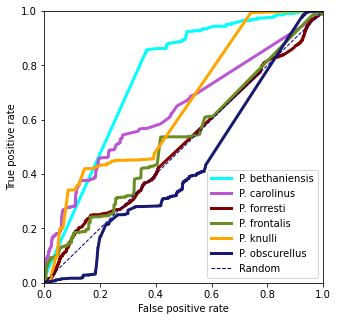

In [6]:
spec_labels=['B. wickershamorum', 'P. bethaniensis', 'P. carolinus', 'P. forresti', 'P. frontalis', 'P. knulli', 'P. obscurellus']
fig,ax=plt.subplots(1,1, figsize=(5, 5))
colormap = {0: 'dodgerblue', 1: 'cyan', 2: 'mediumorchid', 3: 'maroon',
                 4: 'olivedrab', 5: 'orange', 6: 'midnightblue'}


for i, sp in enumerate([df[df['species']==label].iloc[0].species_label for label in literature_labels]):
    fpr, tpr, thresholds = roc_curve(y_true, y_score[:,i].flatten(), pos_label=sp)
    lw = 3
    ax.plot(
        fpr,
        tpr,
        color=colormap[sp],
        lw=lw,
        label=spec_labels[sp],
    )
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
ax.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label="Random")
plt.legend()
plt.show()


Plot confusion matrix.

[Text(0, 0.5, 'P. bethaniensis'),
 Text(0, 1.5, 'P. carolinus'),
 Text(0, 2.5, 'P. forresti'),
 Text(0, 3.5, 'P. frontalis'),
 Text(0, 4.5, 'P. knulli'),
 Text(0, 5.5, 'P. obscurellus')]

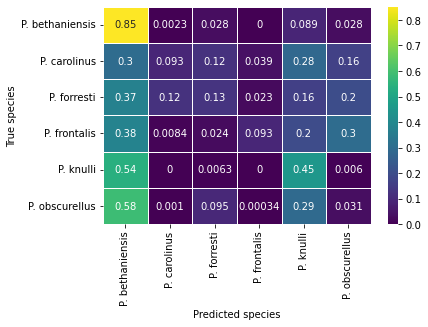

In [7]:
fig,ax = plt.subplots()
sns.heatmap(conf_mat, linewidths=1, cmap='viridis', ax=ax, annot=True, fmt='.2g')
ax.set_ylabel('True species')
ax.set_xlabel('Predicted species')
ax.set_xticklabels(spec_labels[1:], rotation=90)
ax.set_yticklabels(spec_labels[1:], rotation=0)

In [8]:
# Optional: pickle the output
import pickle
data = {
    "acc": acc,
    "prec": prec,
    "rec": rec,
    "conf_mat": conf_mat,
    "y_true": y_true,
    "y_pred": y_pred,
    "y_score": y_score,
    "metrics": metrics
}
with open("dtw_lit", "wb") as f:
        pickle.dump(data, f)

## Classify by computing distance under DTW with population references.

Import results from DTW with population references (using Matlab file dtw_popref.m) and compute classification metrics.

In [ ]:
import matlab.engine
eng = matlab.engine.start_matlab()
eng.dtw_popref(nargout=0)
eng.quit()

Analyze classification results.

In [9]:
y_true = pd.read_csv('dtw_y_true.csv',header=None)
y_pred = pd.read_csv('dtw_y_pred.csv',header=None)
y_score = pd.read_csv('dtw_y_score.csv',header=None)
yt = y_true.to_numpy().reshape((100,int(len(y_true)/100)))
yp = y_pred.to_numpy().reshape((100,int(len(y_pred)/100)))
accs = []
precs = []
recs = []
num_species = len(np.unique(df['species_label']))
num_iter = 100
precs_sp = np.zeros((num_species, num_iter))
recs_sp = np.zeros((num_species,num_iter))
for i in range(100):
    metrics = classification_report(yt[i],yp[i],output_dict=True)
    acc = metrics['accuracy']
    prec = metrics['macro avg']['precision']
    rec = metrics['macro avg']['recall']
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    for sp in range(num_species):
        precs_sp[sp,i] = metrics[str(sp)]['precision']
        recs_sp[sp,i] = metrics[str(sp)]['recall']

In [10]:
spec_labels=['B. wickershamorum', 'P. bethaniensis', 'P. carolinus', 'P. forresti', 'P. frontalis', 'P. knulli', 'P. obscurellus']
print('Overall precision = {0:2.5f}'.format(np.mean(precs)))
print('Overall recall = {0:2.5f}'.format(np.mean(recs)))
for i in range(len(spec_labels)):
    print('{0} precision = {1:2.5f}, recall = {2:2.5f}'.format(spec_labels[i], np.mean(precs_sp[i]), np.mean(recs_sp[i])))

Overall precision = 0.43341
Overall recall = 0.59070
B. wickershamorum precision = 0.45700, recall = 0.55434
P. bethaniensis precision = 0.02829, recall = 0.77647
P. carolinus precision = 0.94902, recall = 0.37342
P. forresti precision = 0.02329, recall = 0.24464
P. frontalis precision = 0.58362, recall = 0.90156
P. knulli precision = 0.38963, recall = 0.69017
P. obscurellus precision = 0.60301, recall = 0.59430


Plot confusion matrix.

[Text(0, 0.5, '1'),
 Text(0, 1.5, '2'),
 Text(0, 2.5, '3'),
 Text(0, 3.5, '4'),
 Text(0, 4.5, '5'),
 Text(0, 5.5, '6'),
 Text(0, 6.5, '7')]

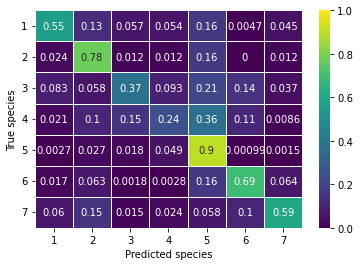

In [11]:
conf_mat = confusion_matrix(y_true,y_pred,normalize='true')
fig,ax = plt.subplots()
sns.heatmap(conf_mat, linewidths=1, cmap='viridis', ax=ax, annot=True, fmt='.2g',vmin=0,vmax=1)
ax.set_ylabel('True species')
ax.set_xlabel('Predicted species')
spec_labels=['1','2','3','4','5','6','7']

ax.set_xticklabels(spec_labels, rotation=0)
ax.set_yticklabels(spec_labels, rotation=0)

Plot ROC curves.

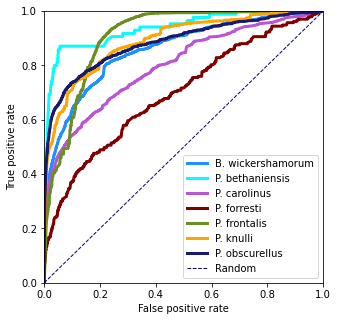

In [12]:
spec_labels=['B. wickershamorum', 'P. bethaniensis', 'P. carolinus', 'P. forresti', 'P. frontalis', 'P. knulli', 'P. obscurellus']
fig,ax=plt.subplots(1,1, figsize=(5, 5))
colormap = {0: 'dodgerblue', 1: 'cyan', 2: 'mediumorchid', 3: 'maroon',
                 4: 'olivedrab', 5: 'orange', 6: 'midnightblue'}

for sp in range(len(np.unique(df['species_label']))):
    fpr, tpr, thresholds = roc_curve(y_true, y_score.to_numpy()[:,sp].flatten(), pos_label=sp)
    lw = 3
    ax.plot(
        fpr,
        tpr,
        color=colormap[sp],
        lw=lw,
        label=spec_labels[sp],
    )
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
ax.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label="Random")
plt.legend()
plt.show()